In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

In [3]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [4]:
from collections import defaultdict
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

sns.set_style("whitegrid")

In [5]:
from pathlib import Path
from hallucinations.utils.metric_loader import get_activation_dirs, load_model_answers, compute_model_results

data_dir = Path("../data/activations/nq_open")

model_answers = load_model_answers(get_activation_dirs(data_dir))
model_results = compute_model_results(model_answers)

Evaluating ROUGE metrics: 100%|██████████| 3610/3610 [00:00<00:00, 9750.75it/s] 


# Difference in erank between pretrain and instruct

In [6]:
from tqdm.notebook import tqdm
from hallucinations.utils.metric_loader import load_model_metrics, process_dataframe

id_cols = ["model", "temperature", "use_token_mask", "squad_f1", "squad_exact_match", "rougeL_fmeasure", "rougeL_precision", "rougeL_recall"]
metric = "diff_erank_pretrain"

dfs = []
model_metrics = load_model_metrics(model_results, metric_type=metric)
for token_mask in ["use_token_mask"]:
    df = pd.DataFrame(model_metrics)
    df = process_dataframe(df, token_mask, metric)  
    dfs.append(df)
df_results = pd.concat(dfs, axis=0)

df_melted = df_results.melt(
    id_vars=id_cols,
    value_vars=[f"{metric}_layer_{i}" for i in range(33)],
    var_name="layer",
    value_name=metric
)
df_melted["layer"] = df_melted["layer"].str.extract("(\d+)").astype(int)
df_melted["correct"] = df_melted["rougeL_fmeasure"].apply(lambda x: 1 if x >= 0.3 else 0)
df_melted["sample_idx"] = df_melted.groupby(["model", "temperature", "use_token_mask", "layer"]).cumcount()

<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3092447/1685291895.py:21: SyntaxWarning: invalid escape sequence '\d'
  df_melted["layer"] = df_melted["layer"].str.extract("(\d+)").astype(int)


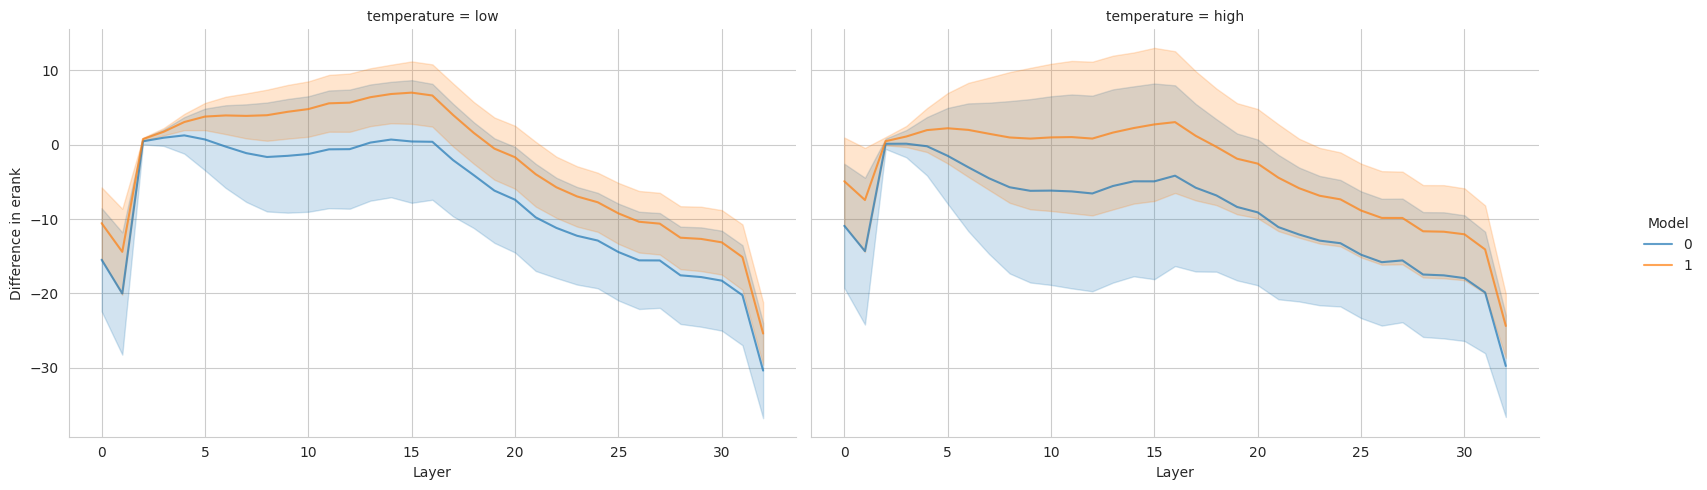

In [7]:
g = sns.FacetGrid(
    data=df_melted[df_melted["diff_erank_pretrain"] != 0.],
    col="temperature",
    height=5,
    aspect=1.5
)

g.map_dataframe(
    sns.lineplot,
    x="layer",
    y="diff_erank_pretrain",
    hue="correct",
    alpha=0.7,
    errorbar="sd",
)

g.set_axis_labels("Layer", "Difference in erank")
g.add_legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title="Model")

plt.tight_layout()
plt.show()


In [8]:
df_melted.head()

,model,temperature,use_token_mask,squad_f1,squad_exact_match,rougeL_fmeasure,rougeL_precision,rougeL_recall,layer,diff_erank_pretrain,correct,sample_idx
0,llama_3.1_8b_instruct,low,1,0.8,0.0,0.8,0.666667,1.0,0,-9.354443,1,0
1,llama_3.1_8b_instruct,low,1,0.5,0.0,0.5,0.500000,0.5,0,-12.98751,1,1
2,llama_3.1_8b_instruct,low,1,0.0,0.0,0.0,0.000000,0.0,0,-15.857778,0,2
3,llama_3.1_8b_instruct,low,1,0.0,0.0,0.0,0.000000,0.0,0,-18.115404,0,3
4,llama_3.1_8b_instruct,low,1,0.0,0.0,0.0,0.000000,0.0,0,-13.044831,0,4


In [9]:
df_melted["sample_idx"]

0            0
1            1
2            2
3            3
4            4
          ... 
238255    3605
238256    3606
238257    3607
238258    3608
238259    3609
Name: sample_idx, Length: 238260, dtype: int64

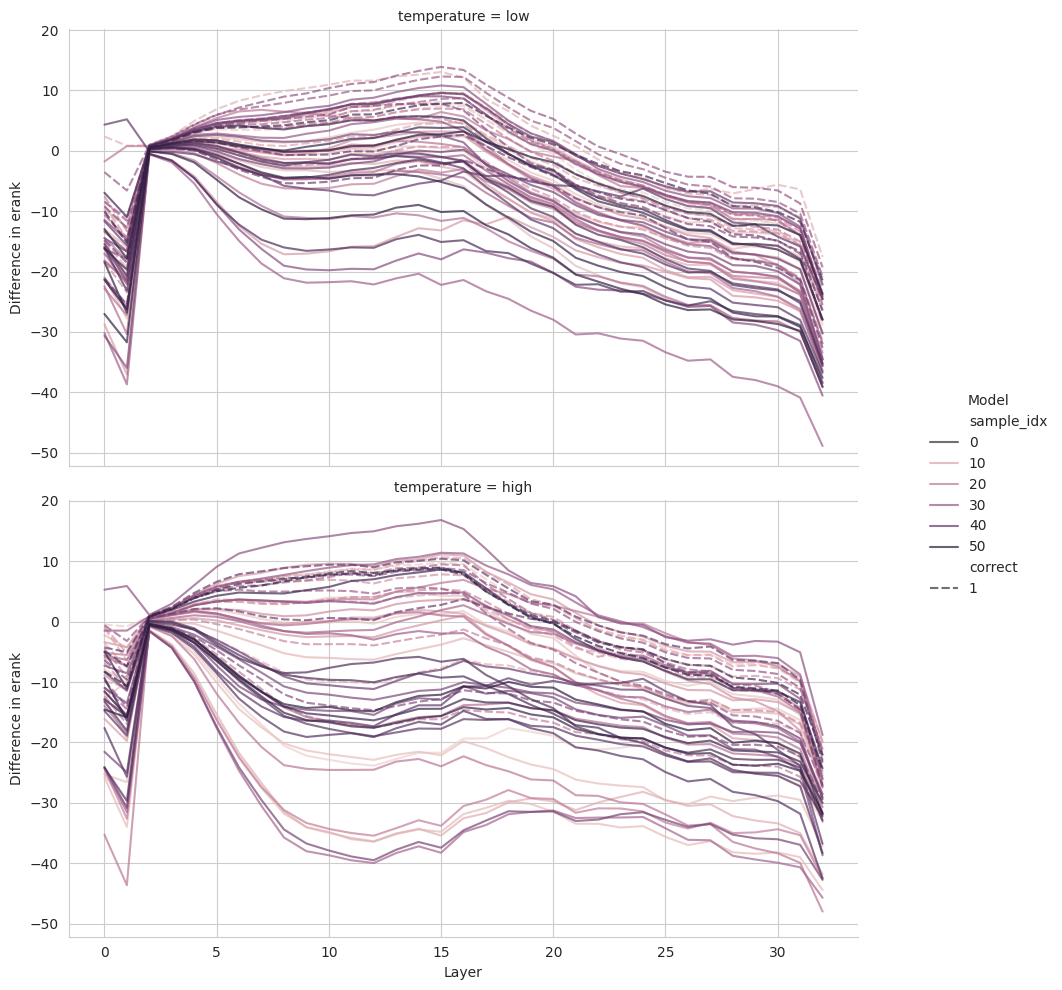

In [10]:
g = sns.FacetGrid(
    data=df_melted[df_melted["sample_idx"] <= 50],
    row="temperature",
    height=5,
    aspect=1.5
)

g.map_dataframe(
    sns.lineplot,
    x="layer",
    y="diff_erank_pretrain",
    hue="sample_idx",
    style="correct",
    alpha=0.7,
    errorbar="sd",
)

g.set_axis_labels("Layer", "Difference in erank")
g.add_legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title="Model")

plt.tight_layout()
plt.show()


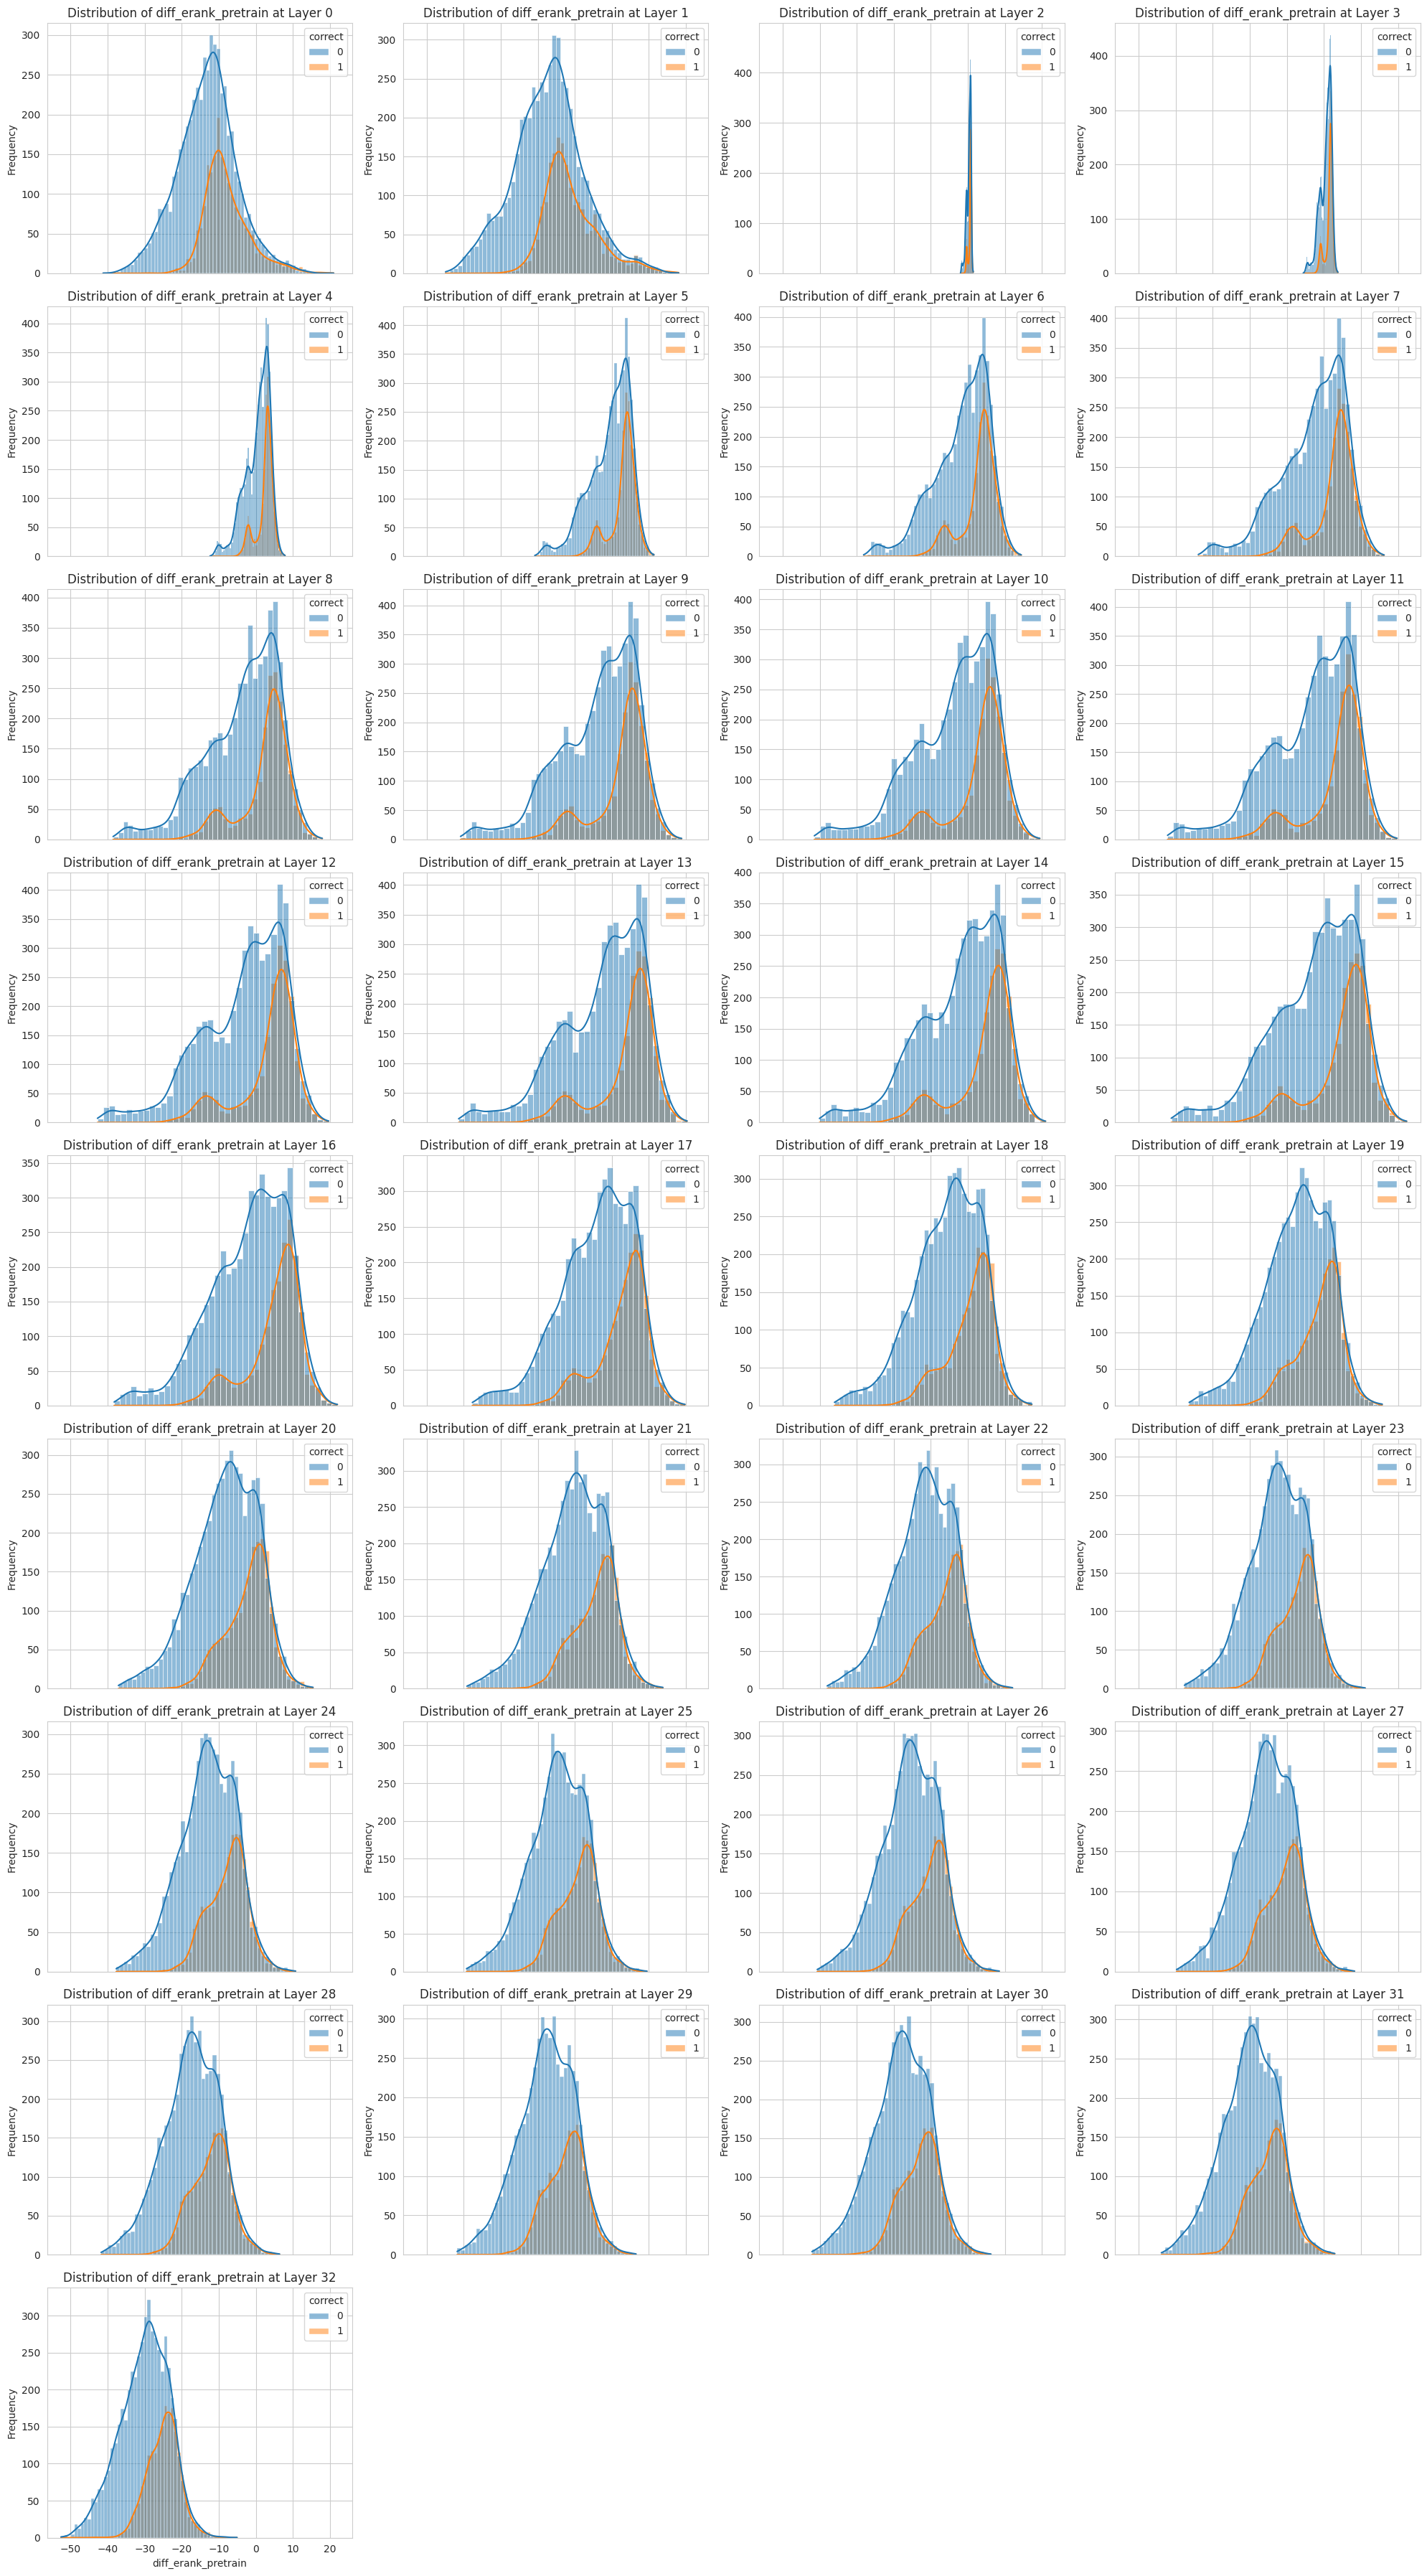

In [11]:

num_layers = df_melted["layer"].max() + 1
num_cols = 4
num_rows = (num_layers // num_cols) + (num_layers % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4), sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i < num_layers:
        sns.histplot(data=df_melted[df_melted["layer"] == i], x="diff_erank_pretrain", hue="correct", kde=True, ax=ax)
        ax.set_title(f'Distribution of diff_erank_pretrain at Layer {i}')
        ax.set_xlabel('diff_erank_pretrain')
        ax.set_ylabel('Frequency')
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()


# Difference in erank between pretrained and untrained

In [24]:
from tqdm.notebook import tqdm
from hallucinations.utils.metric_loader import load_model_metrics, process_dataframe

METRICS = ["diff_erank", "diff_erank_pretrain"]
id_cols = ["model", "temperature", "use_token_mask",  "squad_f1", "squad_exact_match", "rougeL_fmeasure", "rougeL_precision", "rougeL_recall"]

dfs_melted = {}

for metric in tqdm(METRICS):
    dfs = []
    model_metrics = load_model_metrics(model_results, metric_type=metric)
    for token_mask in ["use_token_mask"]:
        df = pd.DataFrame(model_metrics)
        df = process_dataframe(df, token_mask, metric)  
        dfs.append(df)
    df_results = pd.concat(dfs, axis=0)

    df_results = df_results[df_results["model"].isin(["llama_3.1_8b_instruct", "llama_3.1_8b"])]


    df_melted = df_results.melt(
        id_vars=id_cols,
        value_vars=[f"{metric}_layer_{i}" for i in range(33)],
        var_name="layer",
        value_name=metric
    )
    df_melted["layer"] = df_melted["layer"].str.extract("(\d+)").astype(int)
    df_melted["correct"] = df_melted["rougeL_fmeasure"].apply(lambda x: 1 if x >= 0.3 else 0)
    df_melted["sample_idx"] = df_melted.groupby(["model", "temperature", "use_token_mask", "layer"]).cumcount()
    
    dfs_melted[metric] = df_melted


<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2802320/2840211553.py:27: SyntaxWarning: invalid escape sequence '\d'
  df_melted["layer"] = df_melted["layer"].str.extract("(\d+)").astype(int)


  0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
df1 = dfs_melted["diff_erank"]
df_llama = df1[df1["model"] == "llama_3.1_8b"]
df_llama_instruct = df1[df1["model"] == "llama_3.1_8b_instruct"]

df_plot = df_llama.merge(df_llama_instruct[['sample_idx', 'correct']], on='sample_idx', suffixes=('', '_it'))

In [26]:
df_llama.head()

,model,temperature,use_token_mask,squad_f1,squad_exact_match,rougeL_fmeasure,rougeL_precision,rougeL_recall,layer,diff_erank,correct,sample_idx
7220,llama_3.1_8b,high,1,0.666667,0.0,0.666667,1.000000,0.5,0,50.42172,1,0
7221,llama_3.1_8b,high,1,0.057143,0.0,0.054054,0.028571,0.5,0,45.020402,0,1
7222,llama_3.1_8b,high,1,0.058824,0.0,0.050000,0.025641,1.0,0,42.608973,0,2
7223,llama_3.1_8b,high,1,0.000000,0.0,0.000000,0.000000,0.0,0,48.688772,0,3
7224,llama_3.1_8b,high,1,0.125000,0.0,0.111111,0.058824,1.0,0,53.785619,0,4


In [27]:
df_llama_instruct.head()

,model,temperature,use_token_mask,squad_f1,squad_exact_match,rougeL_fmeasure,rougeL_precision,rougeL_recall,layer,diff_erank,correct,sample_idx
0,llama_3.1_8b_instruct,low,1,0.8,0.0,0.8,0.666667,1.0,0,43.946479,1,0
1,llama_3.1_8b_instruct,low,1,0.5,0.0,0.5,0.500000,0.5,0,45.998431,1,1
2,llama_3.1_8b_instruct,low,1,0.0,0.0,0.0,0.000000,0.0,0,37.863656,0,2
3,llama_3.1_8b_instruct,low,1,0.0,0.0,0.0,0.000000,0.0,0,38.39961,0,3
4,llama_3.1_8b_instruct,low,1,0.0,0.0,0.0,0.000000,0.0,0,40.1368,0,4


In [28]:
df_plot.head()

,model,temperature,use_token_mask,squad_f1,squad_exact_match,rougeL_fmeasure,rougeL_precision,rougeL_recall,layer,diff_erank,correct,sample_idx,correct_it
0,llama_3.1_8b,high,1,0.666667,0.0,0.666667,1.0,0.5,0,50.42172,1,0,1
1,llama_3.1_8b,high,1,0.666667,0.0,0.666667,1.0,0.5,0,50.42172,1,0,0
2,llama_3.1_8b,high,1,0.666667,0.0,0.666667,1.0,0.5,0,50.42172,1,0,1
3,llama_3.1_8b,high,1,0.666667,0.0,0.666667,1.0,0.5,0,50.42172,1,0,0
4,llama_3.1_8b,high,1,0.666667,0.0,0.666667,1.0,0.5,0,50.42172,1,0,1


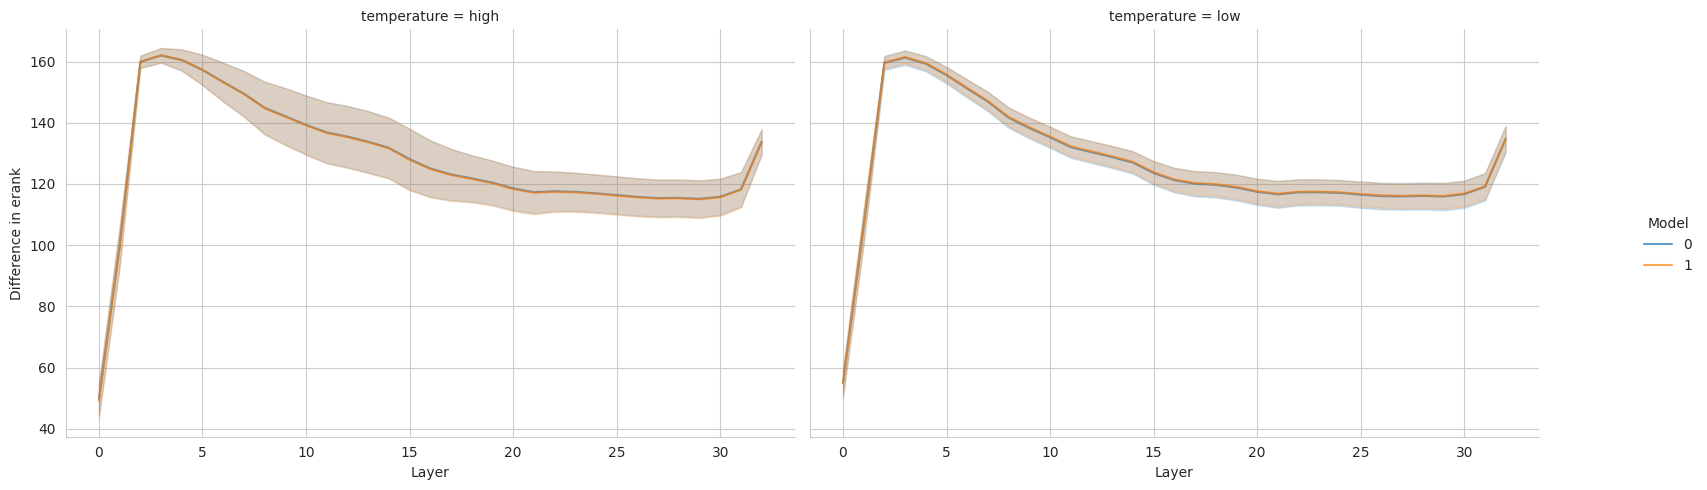

In [29]:
g = sns.FacetGrid(
    data=df_plot,
    col="temperature",
    height=5,
    aspect=1.5
)

g.map_dataframe(
    sns.lineplot,
    x="layer",
    y="diff_erank",
    hue="correct_it",
    alpha=0.7,
    errorbar="sd",
)

g.set_axis_labels("Layer", "Difference in erank")
g.add_legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title="Model")

plt.tight_layout()
plt.show()


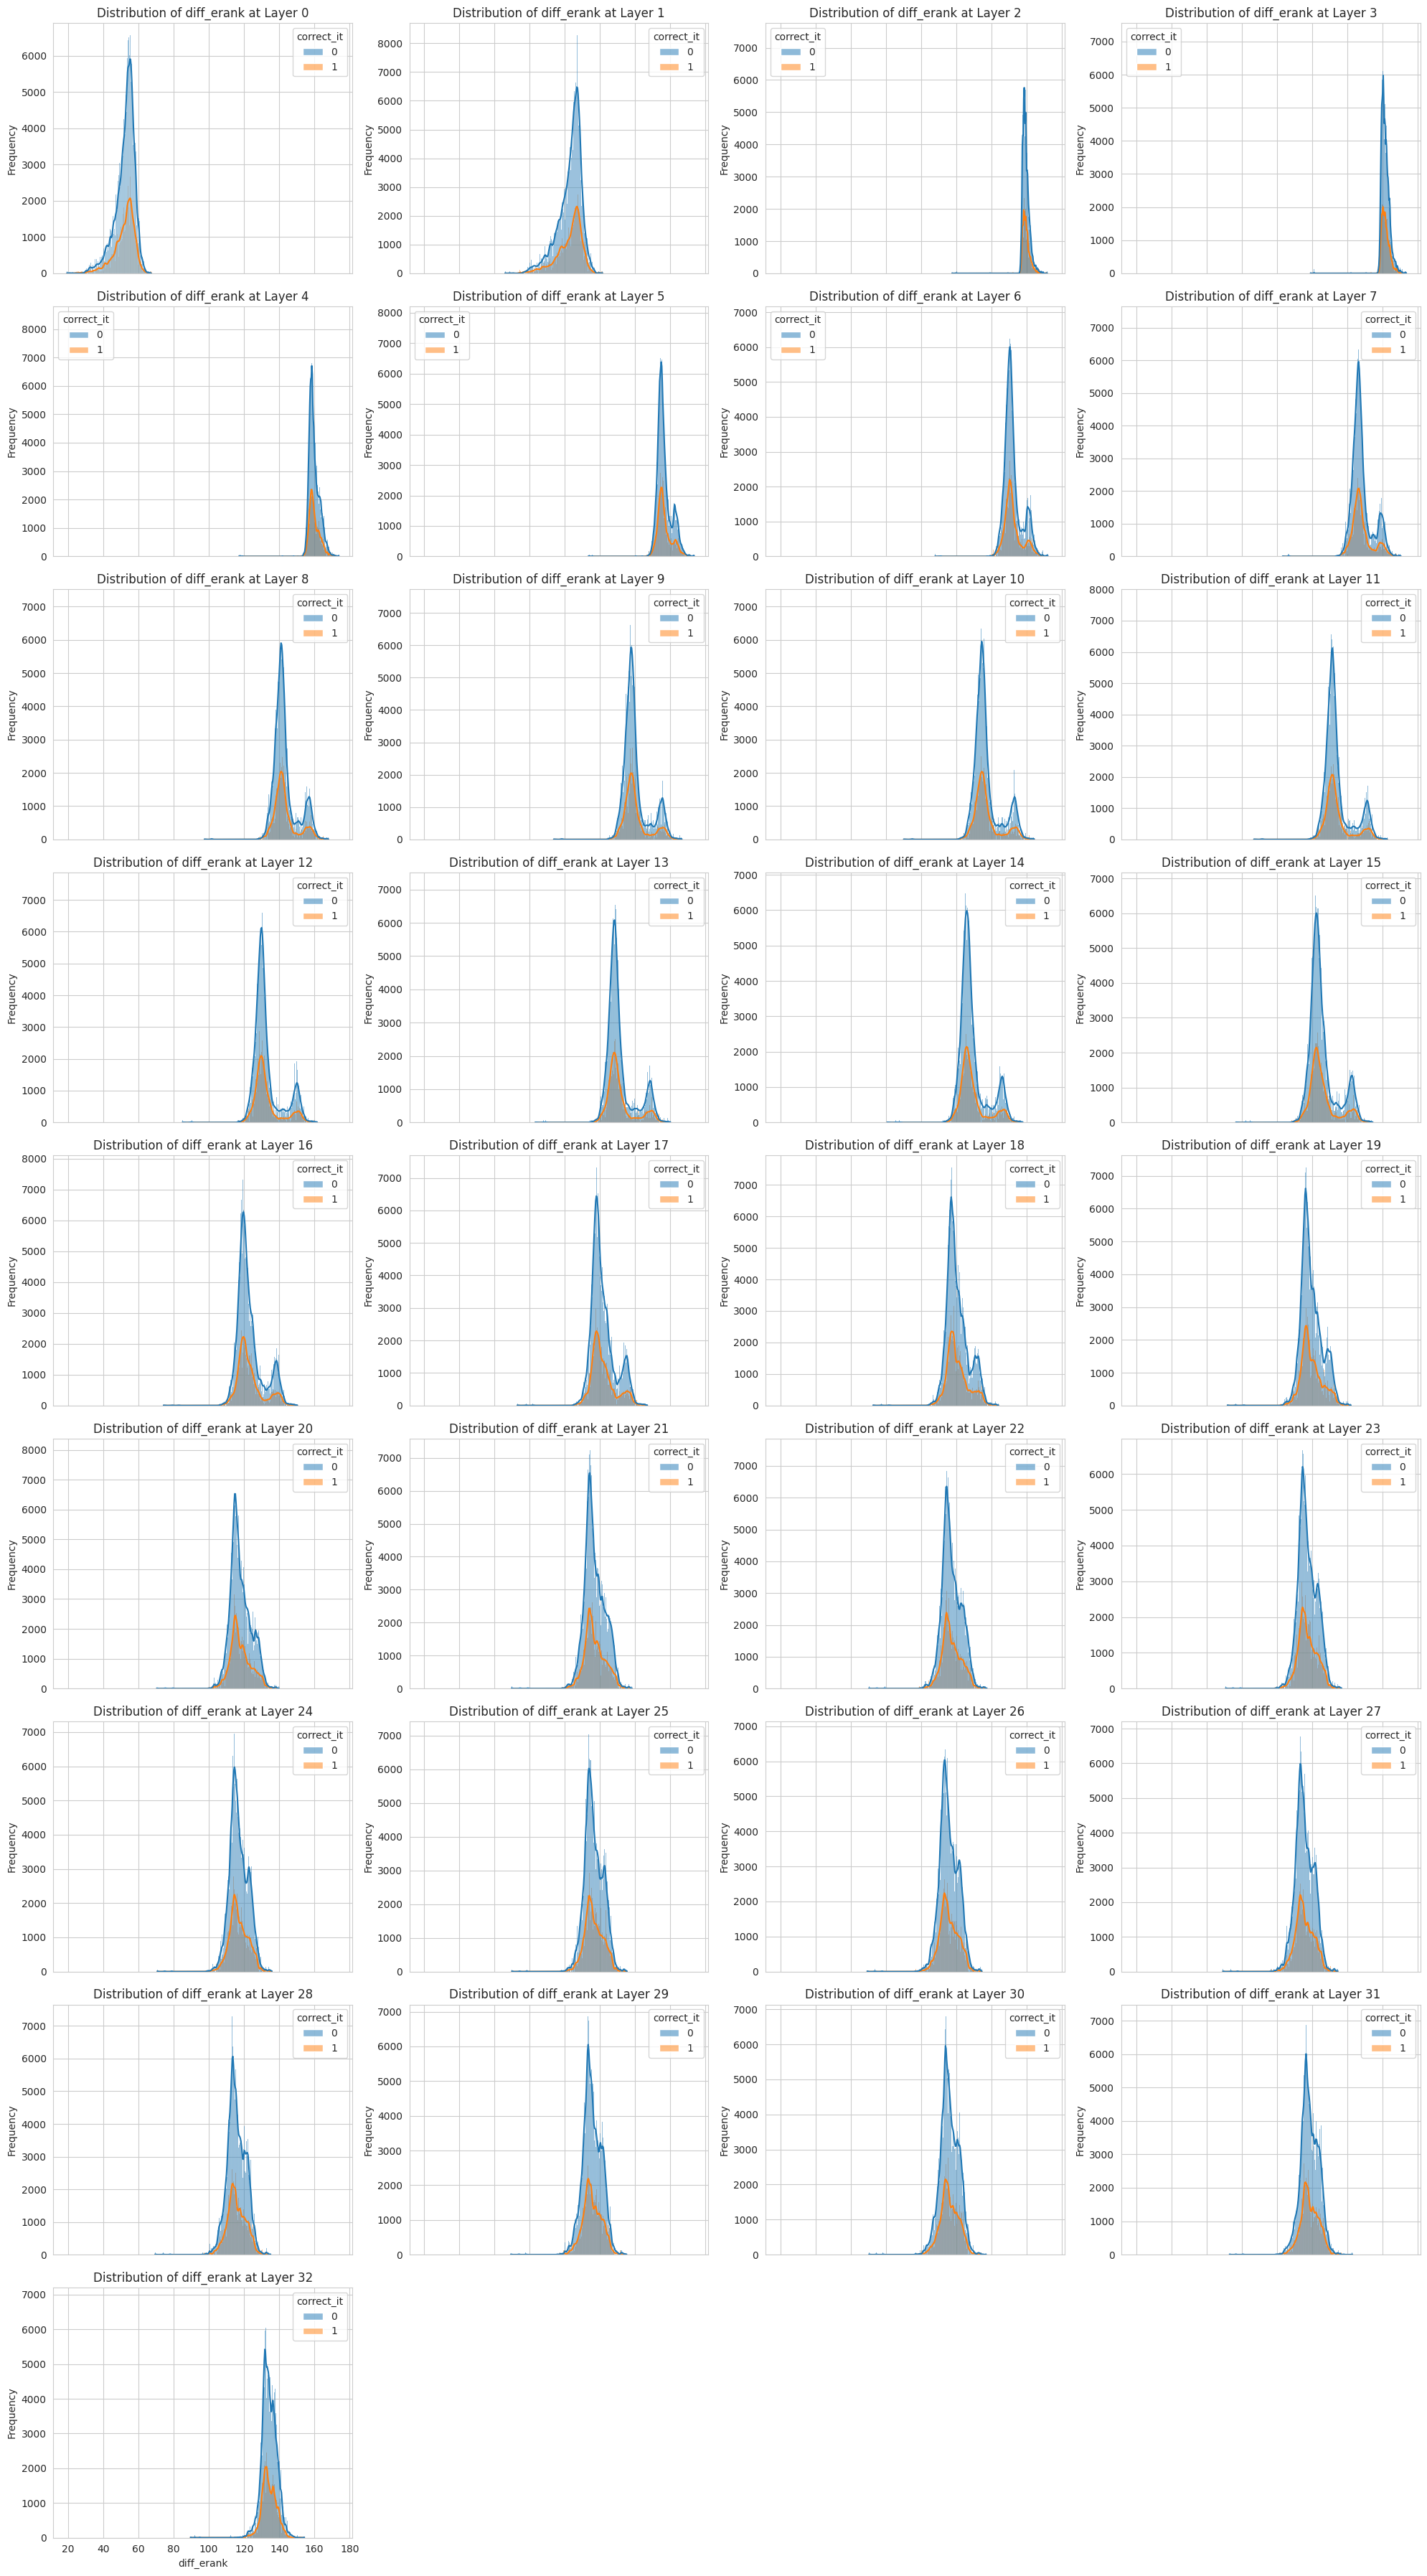

In [30]:

num_layers = df_plot["layer"].max() + 1
num_cols = 4
num_rows = (num_layers // num_cols) + (num_layers % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4), sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i < num_layers:
        layer_data = df_plot[df_plot["layer"] == i]
        sns.histplot(data=layer_data, x="diff_erank", hue="correct_it", kde=True, ax=ax)
        ax.set_title(f'Distribution of diff_erank at Layer {i}')
        ax.set_xlabel('diff_erank')
        ax.set_ylabel('Frequency')
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()
